In [269]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sms
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA

In [270]:
df = pd.read_csv('FX_EURUSD, 1D.csv')
cols = ['time','close']
df = df[cols]

In [271]:
df = df.astype({'time':'datetime64'})
df['date'] = pd.to_datetime(df['time'],unit='s').dt.date
df['date'] = pd.to_datetime(df['date'])
df.drop('time',axis=1,inplace=True)

In [272]:
df.Timestamp = pd.to_datetime(df.date, format='%Y-%m-%d')
df.index = df.Timestamp
df = df.resample('MS').mean()
df = df.asfreq(pd.infer_freq(df.index))

In [273]:
df.head()

,close
date,
2012-10-01,1.298384
2012-11-01,1.283300
2012-12-01,1.312261
2013-01-01,1.331939
2013-02-01,1.330745


Augmented Dickey-Fuller Test. p-value < 0.05 => stationary, unit root < 1. stationary
p-value > 0.05, unit root = 1: not stationary

In [274]:
def adf_test(series):
  result = adfuller(series)
  print('ADF Statistics: {}'.format(result[0]))
  print('p-value: {}'.format(result[1]))
  if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
  else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [275]:
adf_test(df['close'])

ADF Statistics: -2.1489734277601134
p-value: 0.22528324408259248
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [276]:
df['close_diff_1'] = df['close'] - df['close'].shift(1)
df = df[1:]
df.head()

,close,close_diff_1
date,,
2012-11-01,1.283300,-0.015083
2012-12-01,1.312261,0.028960
2013-01-01,1.331939,0.019678
2013-02-01,1.330745,-0.001194
2013-03-01,1.294770,-0.035975


In [277]:
adf_test(df['close_diff_1'])

ADF Statistics: -7.99156655477593
p-value: 2.466504179978003e-12
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


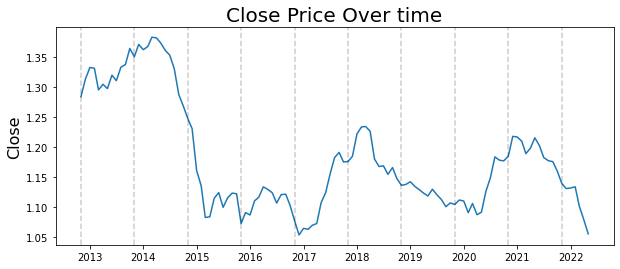

In [278]:
plt.figure(figsize=(10,4))
plt.plot(df.close)
plt.title('Close Price Over time', fontsize=20)
plt.ylabel('Close',fontsize=16)
for year in range(2012, 2022):
  plt.axvline(pd.to_datetime(str(year)+ '-11-01'),color='k', linestyle='--', alpha=0.2)

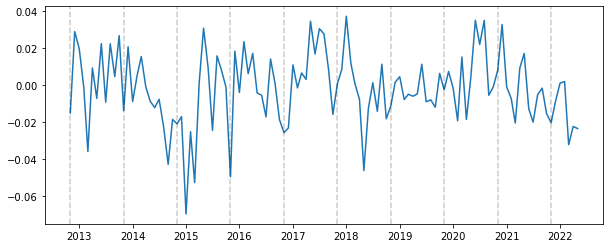

In [279]:
plt.figure(figsize=(10,4))
plt.plot(df.close_diff_1)
for year in range(2012,2022):
    plt.axvline(pd.to_datetime(str(year)+'-11-01'), color='k',linestyle='--',alpha=0.2)

In [280]:
df

,close,close_diff_1
date,,
2012-11-01,1.283300,-0.015083
2012-12-01,1.312261,0.028960
2013-01-01,1.331939,0.019678
2013-02-01,1.330745,-0.001194
2013-03-01,1.294770,-0.035975
...,...,...
2022-01-01,1.131529,0.001019
2022-02-01,1.133420,0.001891
2022-03-01,1.101142,-0.032277


In [281]:
from pmdarima.arima import auto_arima

In [282]:
test_size = 0.3
train_samples = int((1-test_size)*len(df))
train_samples

80

In [283]:
train_data = df[:train_samples]
test_data = df[train_samples:]

In [284]:
pred_start_date = test_data.index[0]
pred_end_date=test_data.index[-1]
pred_start_date, pred_end_date

(Timestamp('2019-07-01 00:00:00', freq='MS'),
 Timestamp('2022-05-01 00:00:00', freq='MS'))

AUTO-ARIMA

In [285]:
auto_model = auto_arima(train_data['close'], start_p=1, start_q=1,
                      max_p=5, max_q=5,
                      m=12,             
                      d=1,          
                      seasonal=False,   
                      start_P=1, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-388.746, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-384.897, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-389.010, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-386.909, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-386.196, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-390.253, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-390.598, Time=0.17 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-392.203, Time=0.12 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-390.473, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-391.000, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-392.892, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-394.800, Time=0.24 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-392.755, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-393.568, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept

In [286]:
auto_model.aic()

-396.58079681377956

In [287]:
df

,close,close_diff_1
date,,
2012-11-01,1.283300,-0.015083
2012-12-01,1.312261,0.028960
2013-01-01,1.331939,0.019678
2013-02-01,1.330745,-0.001194
2013-03-01,1.294770,-0.035975
...,...,...
2022-01-01,1.131529,0.001019
2022-02-01,1.133420,0.001891
2022-03-01,1.101142,-0.032277


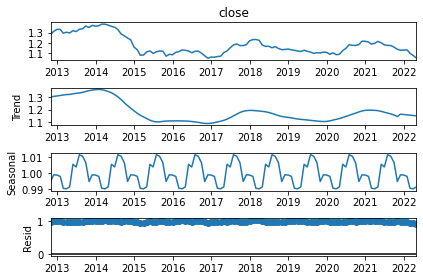

In [288]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['close'], model='multiplicative', extrapolate_trend='freq')
result.plot()
plt.show()

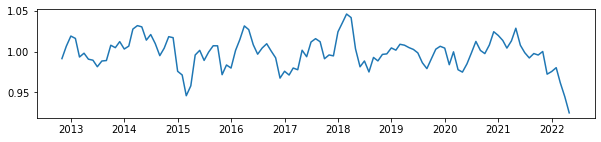

In [289]:
plt.figure(figsize=(10,2))
plt.plot(result.resid)

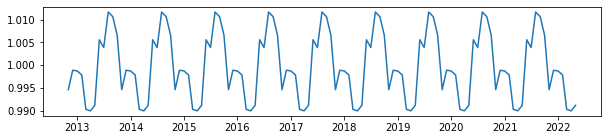

In [290]:
plt.figure(figsize=(10,2))
plt.plot(result.seasonal)

In [291]:
auto_model

ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [292]:
auto_model.fit(train_data['close'])

ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [293]:
future_forecast = auto_model.predict(n_periods=len(test_data))

In [294]:
future_forecast = pd.DataFrame(future_forecast, index=test_data.index,columns=['Prediction'])
future_forecast.head()

,Prediction
date,
2019-07-01,1.134305
2019-08-01,1.136611
2019-09-01,1.137509
2019-10-01,1.138031
2019-11-01,1.138147


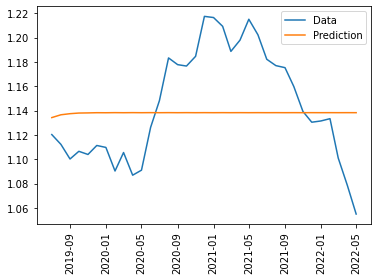

In [295]:
plt.plot(test_data['close'])
plt.plot(future_forecast)
plt.xticks(rotation='vertical')
plt.legend(('Data','Prediction'))

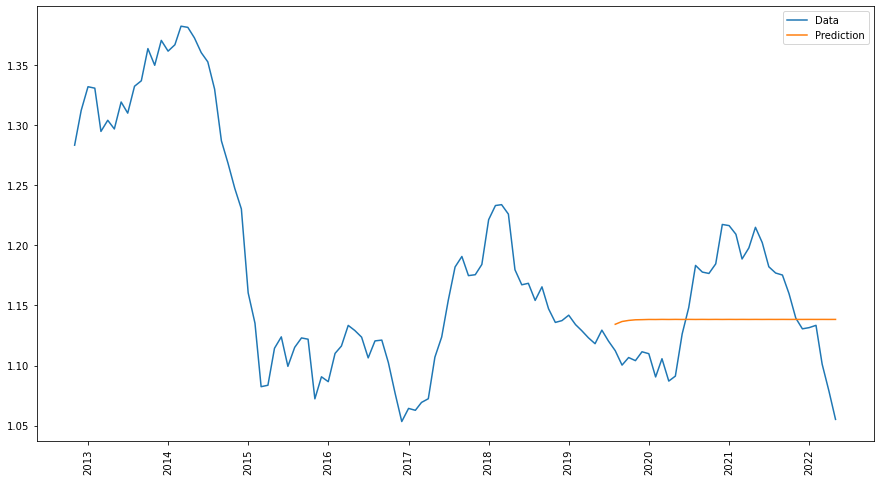

In [296]:
plt.figure(figsize=(15,8))
plt.plot(df['close'])
plt.plot(future_forecast.shift(1))
plt.xticks(rotation='vertical')
plt.legend(('Data','Prediction'))
plt.show()

In [297]:
future_forecast = auto_model.predict(n_periods=len(test_data)+12)
future_forecast

array([1.13430533, 1.13661098, 1.13750927, 1.13803086, 1.13814728,
       1.13830918, 1.13827658, 1.13836159, 1.13830479, 1.13836951,
       1.13831273, 1.13836884, 1.13831643, 1.13836669, 1.13831909,
       1.13836443, 1.13832135, 1.13836233, 1.13832337, 1.13836042,
       1.13832519, 1.13835869, 1.13832684, 1.13835713, 1.13832832,
       1.13835572, 1.13832967, 1.13835444, 1.13833088, 1.13835328,
       1.13833198, 1.13835224, 1.13833298, 1.13835129, 1.13833388,
       1.13835044, 1.13833469, 1.13834966, 1.13833542, 1.13834896,
       1.13833609, 1.13834833, 1.13833669, 1.13834776, 1.13833723,
       1.13834724, 1.13833773])

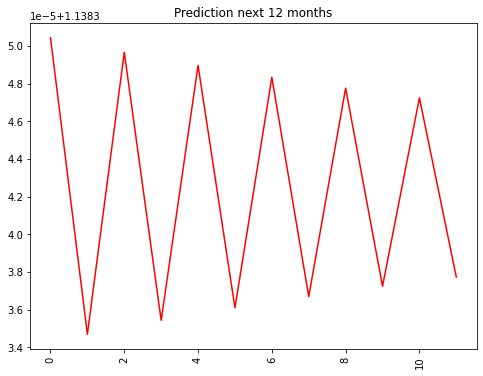

In [298]:
plt.figure(figsize=(8,6))
plt.plot(future_forecast[len(test_data):], color='red')
plt.xticks(rotation='vertical')
plt.title('Prediction next 12 months')
plt.show()

In [299]:
test_data

,close,close_diff_1
date,,
2019-07-01,1.120366,-0.009062
2019-08-01,1.112334,-0.008032
2019-09-01,1.100335,-0.011999
2019-10-01,1.106637,0.006302
2019-11-01,1.104047,-0.002590
2019-12-01,1.111429,0.007382
2020-01-01,1.109825,-0.001603
2020-02-01,1.090483,-0.019343
2020-03-01,1.105645,0.015163


In [300]:
months = pd.date_range('2022-06-01','2023-05-02',freq='MS').strftime('%Y-%m-%d').tolist()

In [301]:
months

['2022-06-01',
 '2022-07-01',
 '2022-08-01',
 '2022-09-01',
 '2022-10-01',
 '2022-11-01',
 '2022-12-01',
 '2023-01-01',
 '2023-02-01',
 '2023-03-01',
 '2023-04-01',
 '2023-05-01']

In [302]:
new_predict = pd.DataFrame({
    'DATE': months,
    'Close':future_forecast[len(test_data):]
})
new_predict

,DATE,Close
0,2022-06-01,1.138350
1,2022-07-01,1.138335
2,2022-08-01,1.138350
3,2022-09-01,1.138335
4,2022-10-01,1.138349
5,2022-11-01,1.138336
6,2022-12-01,1.138348
7,2023-01-01,1.138337
8,2023-02-01,1.138348
9,2023-03-01,1.138337


In [303]:
# #Rolling Forecast
# test_data_index = pd.date_range('2019-07-01','2023-05-01',freq='MS').strftime('%Y-%m-%d')
# test_data_index = pd.to_datetime(test_data_index)
# test_data_index.freq = 'MS'

In [304]:
auto_model

ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [305]:
train_data

,close,close_diff_1
date,,
2012-11-01,1.283300,-0.015083
2012-12-01,1.312261,0.028960
2013-01-01,1.331939,0.019678
2013-02-01,1.330745,-0.001194
2013-03-01,1.294770,-0.035975
...,...,...
2019-02-01,1.134025,-0.007847
2019-03-01,1.129053,-0.004972
2019-04-01,1.123013,-0.006041


In [306]:
len(test_data_index)

47

In [307]:
print(len(predictions_rolling_ARIMA))

47


In [308]:
predictions_rolling_ARIMA

[array([1.13430533, 1.13661098, 1.13750927, 1.13803086, 1.13814728,
        1.13830918, 1.13827658, 1.13836159, 1.13830479, 1.13836951]),
 array([1.11759976, 1.11540565, 1.11548029, 1.11453844, 1.11508857,
        1.11439852, 1.11500495, 1.1143872 , 1.11497687, 1.11439804]),
 array([1.10855572, 1.10734812, 1.1064648 , 1.10645782, 1.10609884,
        1.10629474, 1.10603881, 1.10626098, 1.10603284, 1.10625042]),
 array([1.09703007, 1.09360682, 1.09392127, 1.09231552, 1.093252  ,
        1.09210402, 1.09307465, 1.09210327, 1.09299998, 1.09214031]),
 array([1.10547569, 1.10885269, 1.10594715, 1.10844705, 1.10629616,
        1.10814676, 1.10655452, 1.10792447, 1.10674578, 1.10775992]),
 array([1.10502857, 1.10341245, 1.10475219, 1.10331855, 1.10469582,
        1.10331371, 1.10467595, 1.10332337, 1.10466231, 1.10333523]),
 array([1.11077503, 1.11421454, 1.11222496, 1.11466729, 1.112611  ,
        1.11466592, 1.11277454, 1.11458385, 1.11288441, 1.11449448]),
 array([1.11186158, 1.10819314, 1.

HOLT-WINTERS

In [309]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model_holwinter = ExponentialSmoothing(train_data['close'], seasonal='mul', seasonal_periods=12).fit()
pred_holtwinter = model_holwinter.predict(start=pred_start_date, end=pred_end_date)

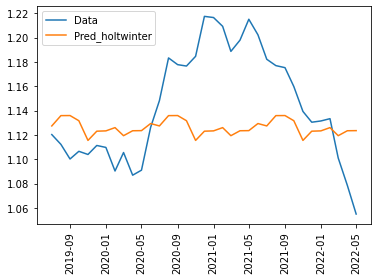

In [310]:
plt.plot(test_data['close'])
plt.plot(pred_holtwinter)
plt.xticks(rotation='vertical')
plt.legend(('Data','Pred_holtwinter'))
plt.show()

ARMA

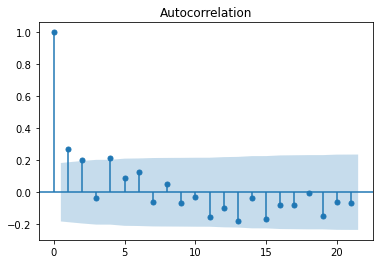

In [311]:
acf_plot = plot_acf(df.close_diff_1)

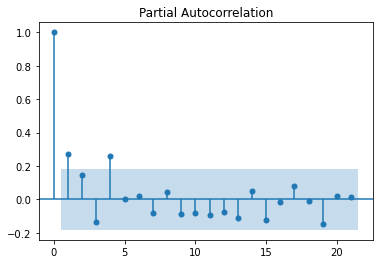

In [312]:
pacf_plot = plot_pacf(df.close_diff_1)

In [313]:
model_arma = ARMA(train_data['close'], order=(1,2))
model_fit_arma = model_arma.fit()
model_fit_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  close   No. Observations:                   80
Model:                     ARMA(1, 2)   Log Likelihood                 201.802
Method:                       css-mle   S.D. of innovations              0.019
Date:                Tue, 31 May 2022   AIC                           -393.604
Time:                        16:53:34   BIC                           -381.694
Sample:                    11-01-2012   HQIC                          -388.829
                         - 06-01-2019                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.1966      0.054     22.147      0.000       1.091       1.302
ar.L1.close     0.9470      0.033     28.736      0.000       0.882       1.012
ma.L1.close     0.3325      0.122      2.726      0.006       0.093       0.572
ma.L2.close     0.2955      0.101      2.913      0.004       0.097       0.494
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0559           +0.0000j            1.0559            0.0000
MA.1           -0.5626           -1.7514j            1.8395           -0.2995
MA.2           -0.5626           +1.7514j            1.8395            0.2995
-----------------------------------------------------------------------------
"""

In [314]:
predictions_arma = model_fit_arma.predict(start=pred_start_date, end=pred_end_date)

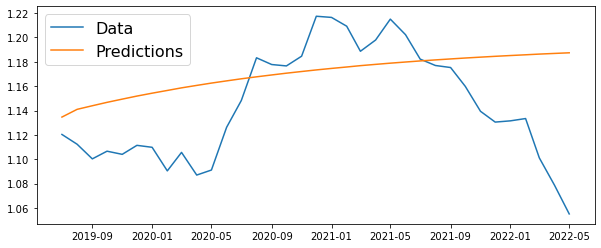

In [315]:
plt.figure(figsize=(10,4))
plt.plot(test_data['close'])
plt.plot(predictions_arma)
plt.legend(('Data','Predictions'), fontsize=16)

Rolling Forecast
Predict 1 month in advance (one month ahead each time)

In [316]:
predictions_rolling = pd.Series()
for end_date in test_data.index:
    train_data = df[:end_date - timedelta(days=1)]
    model_3 = ARMA(train_data['close'], order=(1,1))
    model_fit_3 = model_3.fit()
    pred_3 = model_fit_3.predict(end_date)
    predictions_rolling.loc[end_date] = pred_3.loc[end_date]

In [317]:
residuals_rolling = test_data['close'] - predictions_rolling

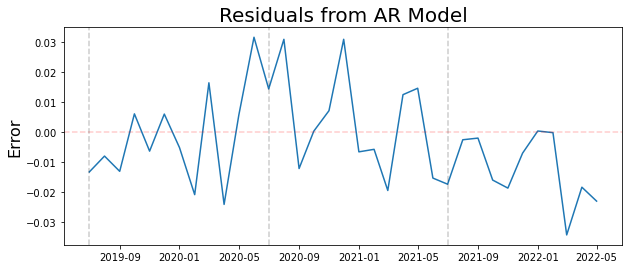

In [318]:
plt.figure(figsize=(10,4))
plt.plot(residuals_rolling)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r',linestyle='--',alpha=0.2)
for year in range(2019,2022):
    plt.axvline(pd.to_datetime(str(year)+'-07-01'), color='k', linestyle='--',alpha=0.2)

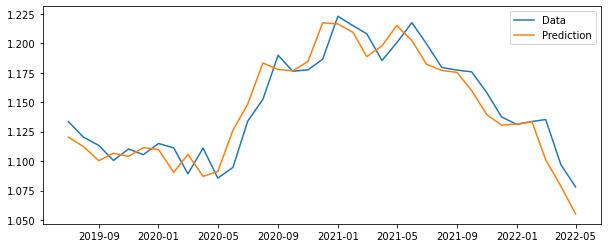

In [319]:
plt.figure(figsize=(10,4))
plt.plot(predictions_rolling)
plt.plot(test_data['close'])
plt.legend(('Data','Prediction'))

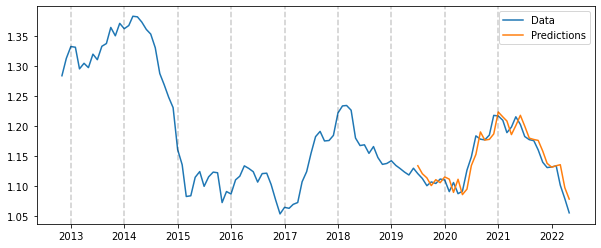

In [320]:
plt.figure(figsize=(10,4))
plt.plot(df['close'])
plt.plot(predictions_rolling)
plt.legend(('Data','Predictions'))
for year in range(2013,2022):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--',alpha=0.2)

In [321]:
print('Mean Absolute Percent Error: ', round(np.mean(abs(residuals_rolling/test_data['close'])),4))

Mean Absolute Percent Error:  0.0117


In [322]:
print('Root Mean Squared Error: ', np.sqrt(np.mean(residuals_rolling**2)))

Root Mean Squared Error:  0.01620810237540674
